In [1]:
#imports
import torch
import torch.utils.data as data
from torch.utils.data.dataset import Dataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import random
from PIL import Image
import os
import csv
import glob

import matplotlib.pyplot as plt

## Load CIFAR-10

Sources and references on CIFAR-10 and dataloeading with PYTORCH :

- download : https://www.cs.toronto.edu/~kriz/cifar.html
- https://www.youtube.com/watch?v=pBOfQTfDMVg&ab_channel=BinaryStudy
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html


In [2]:
_CIFAR_DATASET_DIR = './datasets/CIFAR'

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# List all files and directories
print(os.listdir(_CIFAR_DATASET_DIR))

['data_batch_1', 'readme.html', 'batches.meta', 'data_batch_2', 'data_batch_5', 'test_batch', 'data_batch_4', 'data_batch_3']


In [5]:
#get all batches
data_batches = glob.glob(_CIFAR_DATASET_DIR + '/*data_batch*') # just a list of all files directories 

In [6]:
data_batches

['./datasets/CIFAR/data_batch_1',
 './datasets/CIFAR/data_batch_2',
 './datasets/CIFAR/data_batch_5',
 './datasets/CIFAR/data_batch_4',
 './datasets/CIFAR/data_batch_3']

In [12]:
batch_1 = unpickle(data_batches[0]) #same as bat = unpickle('./datasets/CIFAR/data_batch_1')


In [16]:
type(batch_1)

dict

In [17]:
len(batch_1)

4

In [18]:
batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

> "b'data'" : images

In [19]:
batch_1[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [20]:
batch_1[b'data'].shape

(10000, 3072)

> - 10_000 images, chaque image (= une ligne) a 3072 pixels ( = 3 * 1024 = 1024 Red + 1024 Green + 1024 Blue)

In [21]:
# 1ère image 
batch_1[b'data'][0]

array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)

In [22]:
batch_1[b'data'][0].shape

(3072,)

> to visualize an image we have to reshape it : 
> here everything is flattened : the image should be a superposition of the 3 colors channels, each of shape 32 * 32 = 1024, so we : 
> - reshape (3, 32, 32)
> - transpose (32, 32, 3) 

In [27]:
first_image = batch_1[b'data'][32].reshape(3, 32, 32).transpose(1, 2, 0)

In [42]:
first_image[:2, :2, :2]
#1st column = red, 2nd column = green, 3rd column = blue

array([[[ 50,  64],
        [ 51,  63]],

       [[ 86, 107],
        [ 92, 110]]], dtype=uint8)

## Visualization 

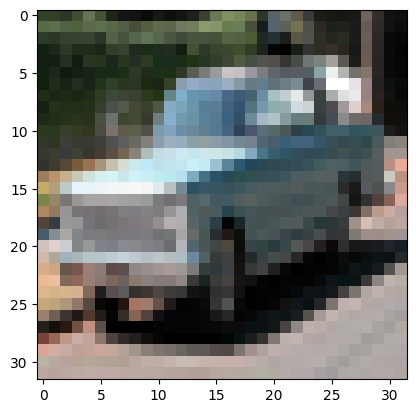

In [28]:
plt.imshow(first_image)

## Rotation 

In [7]:
"""
Takes in an image and a rotation. Returns the the image with the rotation applied.
"""
def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 90: # 90 degrees rotation
        return np.flipud(np.transpose(img, (1,0,2)))
    elif rot == 180: # 90 degrees rotation
        return np.fliplr(np.flipud(img))
    elif rot == 270: # 270 degrees rotation / or -90
        return np.transpose(np.flipud(img), (1,0,2))
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

In [30]:
test = rotate_img(first_image, 90)

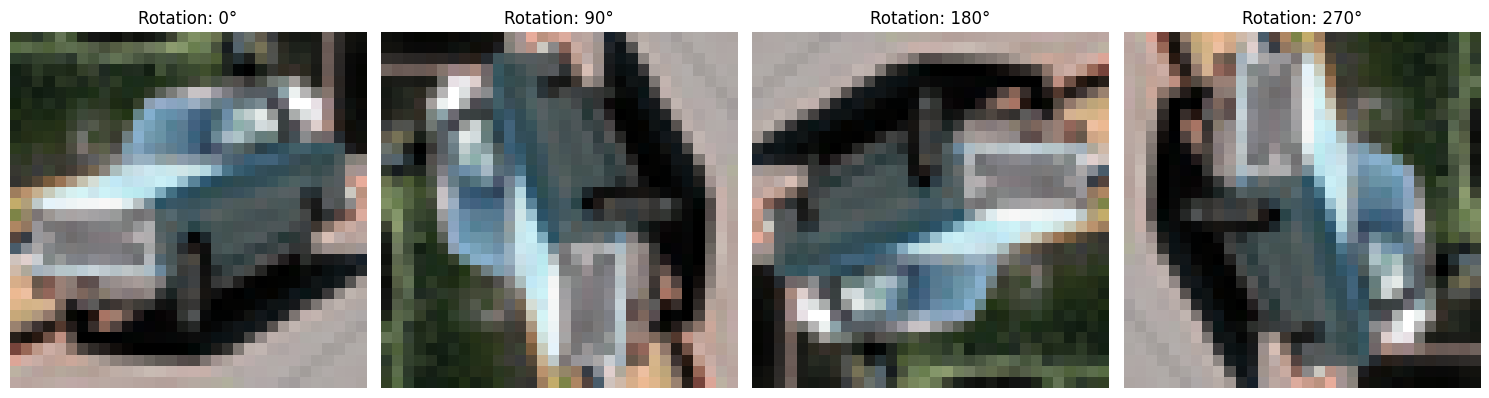

In [33]:
rotations = [0, 90, 180, 270]
rotated_images = [rotate_img(first_image, rot) for rot in rotations]

fig, axes = plt.subplots(1, len(rotations), figsize=(15, 5))

for ax, img, rot in zip(axes, rotated_images, rotations):
    ax.imshow(img)
    ax.set_title(f"Rotation: {rot}°")
    ax.axis("off")  # Turn off axis labels

plt.tight_layout()
plt.show()

    

> les rotations sont définies dans le sens trigonométriques 

## Récupération des labels 

In [60]:
batches_meta = glob.glob(_CIFAR_DATASET_DIR + '/batches.meta')
batches_meta_ = unpickle(batches_meta[0])

print("Batches meta type : ", type(batches_meta_))
print("Batches meta length : ", len(batches_meta_))
print("Batches meta keys : ", batches_meta_.keys())

labels_names = batches_meta_[b'label_names']


Batches meta type :  <class 'dict'>
Batches meta length :  3
Batches meta keys :  dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])


In [65]:
index_first_image = batch_1[b'labels'][32]
index_first_image

1

In [66]:
labels_names[1]

b'automobile'

> on a bien une automobile 

## Class CIFAR(Dataset)

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import random
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt

# Denormalization class
class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
"""
Takes in an image and a rotation. Returns the the image with the rotation applied.
"""
def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 90: # 90 degrees rotation
        return np.flipud(np.transpose(img, (1,0,2)))
    elif rot == 180: # 90 degrees rotation
        return np.fliplr(np.flipud(img))
    elif rot == 270: # 270 degrees rotation / or -90
        return np.transpose(np.flipud(img), (1,0,2))
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

#on considère qu'on utilise la classe sur des dataset directement (Pytorch), donc on va load les données avec Pytorch
class CIFAR(Dataset):
    def __init__(self, dataset, transform=None, unsupervised=True):
        self.dataset = dataset
        self.transform = transform
        self.unsupervised = unsupervised
        
        # Define the mean and std for normalization
        self.mean_pix = [125.3 / 255.0, 123.0 / 255.0, 113.9 / 255.0]
        self.std_pix = [63.0 / 255.0, 62.1 / 255.0, 66.7 / 255.0]

        # Define transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean_pix, std=self.std_pix),
        ])
        self.inv_transform = transforms.Compose([
            Denormalize(self.mean_pix, self.std_pix),
            lambda x: x.numpy() * 255.0,
            lambda x: x.transpose(1, 2, 0).astype(np.uint8),
        ])

    def __getitem__(self, index):
        img, label = self.dataset[index]

        if self.unsupervised:
            # Generate rotated images
            rotated_imgs = [
                self.transform(img),
                self.transform(rotate_img(img, 90).copy()),
                self.transform(rotate_img(img, 180).copy()),
                self.transform(rotate_img(img, 270).copy()),
            ]
            # Generate the rotation labels
            rotation_labels = torch.LongTensor([0, 1, 2, 3])
            return torch.stack(rotated_imgs, dim=0), rotation_labels
        else:
            # In supervised mode, no rotations 
            img = self.transform(img)
            return img, label

    def __len__(self):
        return len(self.dataset)

#on n'a pas besoin de créer une nouvelle classe Dataloader
def get_dataloader(dataset, batch_size=1, unsupervised=True, num_workers=0, shuffle=True):
    # Define transforms
    mean_pix = [125.3 / 255.0, 123.0 / 255.0, 113.9 / 255.0]
    std_pix = [63.0 / 255.0, 62.1 / 255.0, 66.7 / 255.0]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_pix, std=std_pix),
    ])

    # Create the dataset
    rotated_dataset = CIFAR(dataset=dataset, transform=transform, unsupervised=unsupervised)

    # Custom collate function for unsupervised mode
    def custom_collate_fn(batch):
        if unsupervised:
            images, labels = zip(*batch)
            images = torch.cat(images, dim=0)  # Flatten the rotated images
            labels = torch.cat(labels, dim=0)  # Flatten the labels
            return images, labels
        else:
            return torch.utils.data.dataloader.default_collate(batch)

    # Create DataLoader
    data_loader = DataLoader(
        dataset=rotated_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=custom_collate_fn if unsupervised else None,
    )
    

    return data_loader # return images, labels


## Checks of Dataset and Dataloader : shapes, vizualisation, retrival of original images...

In [2]:


# Load CIFAR-10 dataset
train_dataset = CIFAR10(root="./data", train=True, download=True)

100%|██████████| 170498071/170498071 [00:07<00:00, 22528053.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
# Get DataLoader for unsupervised mode
train_loader = get_dataloader(train_dataset, batch_size=32, unsupervised=True, shuffle=True)

# Iterate through the DataLoader
for images, rotation_labels in train_loader:
    print(f"Images batch shape: {images.shape}")  # Should be [128, 3, 32, 32]
    print(f"Labels batch shape: {rotation_labels.shape}")  # Should be [128]
    break

Images batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9162642..2.011111].


Batch index: 0
Images shape: torch.Size([128, 3, 32, 32])
Labels shape: torch.Size([128])
First image shape: torch.Size([3, 32, 32])
First label: 0


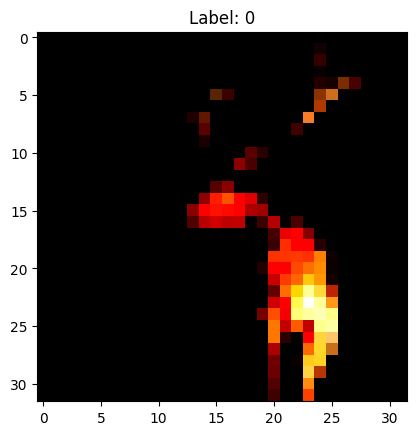

In [8]:
# Iterate through the DataLoader
for batch_idx, (images, rotation_labels) in enumerate(train_loader):
    print(f"Batch index: {batch_idx}")
    print(f"Images shape: {images.shape}")  # Shape: [batch_size, channels, height, width]
    print(f"Labels shape: {rotation_labels.shape}")  # Shape: [batch_size]
    
    # Access the first image in the batch
    first_image = images[0]
    first_label = rotation_labels[0]
    print(f"First image shape: {first_image.shape}")  # Shape: [channels, height, width]
    print(f"First label: {first_label}")
    
    # Visualize the image (if needed)
    plt.imshow(first_image.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C] for display
    plt.title(f"Label: {first_label}")
    plt.show()
    
    # Break to avoid loading all batches
    break


## Retrieve original images

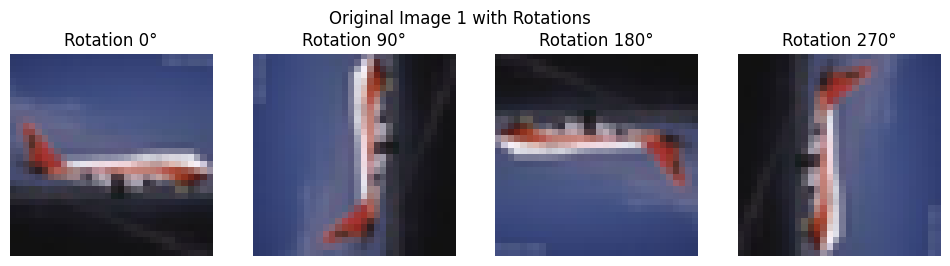

In [16]:
# Assume train_loader is already created and outputs shape [batch_size*4, channels, height, width]
images, rotation_labels = next(iter(train_loader))  # Fetch a batch of data

# Number of images per batch and rotations per image
batch_size = images.shape[0] // 4

# Reshape to group by original images: [batch_size, 4, channels, height, width]
grouped_images = images.view(batch_size, 4, *images.shape[1:])  # Now each entry has 4 rotations

# De-transform and visualize each set of rotations for one image
for i in range(batch_size):  # Iterate over each original image in the batch
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    
    for j in range(4):  # Iterate over the 4 rotated versions of the image
        # De-transform the image
        de_transformed_image = train_loader.dataset.inv_transform(grouped_images[i, j])

        # Visualize
        axes[j].imshow(de_transformed_image)  # Ensure [H, W, C]
        axes[j].set_title(f"Rotation {j * 90}°")
        axes[j].axis("off")
    
    plt.suptitle(f"Original Image {i + 1} with Rotations")
    plt.show()

    # Break after visualizing the first image in the batch (optional)
    break


# ESSAIS 

In [ ]:
### Dans la class CIFAR(Dataset) on iplémente __init__, __getitem__ et __len__ 

class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class CIFAR(Dataset):
    def __init__(self, data_dir, split, num_imgs_per_cat=None):
        """
        Args:
            data_dir (string): Directory with all the images
        """
        self.data_dir = data_dir
        self.image_list = glob.glob(data_dir)
        self.data_len = len(self.image_list)
        self.split = split.lower()

        # The num_imgs_per_cats input argument specifies the number
        # of training examples per category that would be used.
        # This input argument was introduced in order to be able
        # to use less annotated examples than what are available
        # in a semi-superivsed experiment. By default all the 
        # available training examplers per category are being used.
        #TODO: implement fct that uses num_imgs_per_cat
        self.num_imgs_per_cat = num_imgs_per_cat 
        
        #pre-processing
        self.mean_pix = [x / 255.0 for x in [125.3, 123.0, 113.9]]
        self.std_pix = [x / 255.0 for x in [63.0, 62.1, 66.7]]
        
        transform = []
        #if (split != 'test'):
        #    transform.append(transforms.RandomCrop(32, padding=4))
        #    transform.append(transforms.RandomHorizontalFlip())
        
        transform.append(lambda x: np.asarray(x))
        self.transform = transforms.Compose(transform)
        
        mean_pix  = self.dataset.mean_pix
        std_pix   = self.dataset.std_pix
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_pix, std=std_pix)
        ])
        self.inv_transform = transforms.Compose([
            Denormalize(mean_pix, std_pix),
            lambda x: x.numpy() * 255.0,
            lambda x: x.transpose(1,2,0).astype(np.uint8),
        ])
        
        
    def __getitem__(self, index):
        img, label = self.data[index]
        return img, int(label)

    def __len__(self):
        return len(self.data)

